##### Load Dataset to Pandas Dataframe

In [1]:
import pandas as pd

df__spam_dataset = pd.read_csv('spam_dataset.csv')
df__spam_dataset.head()

print(f'Dataframe shape: {df__spam_dataset.shape}')

Dataframe shape: (124075, 2)


##### Data Preprocessing

In [2]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import LabelEncoder
from bs4 import BeautifulSoup # For HTML parsing
from bs4 import MarkupResemblesLocatorWarning # Import the specific warning
import unicodedata # For character normalization
from collections import Counter # For rare word filtering
import os # For file path operations
import warnings # For warning management
import emoji # For emoji handling
import contractions # Import the contractions library


# --- Suppress BeautifulSoup warnings ---
# Warnings related to MarkupResemblesLocator are ignored.
warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)

# --- Global Configurations and NLTK Downloads ---

# Define the path for the preprocessed CSV file.
PREPROCESSED_FILE_PATH = 'spam_dataset_preprocessed.csv'

# A function is defined to safely manage NLTK data downloads.
# It checks if a resource is already available before initiating a download,
# preventing unnecessary re-downloads and handling potential errors.
def safe_nltk_download(resource_path, download_name):
    try:
        nltk.data.find(resource_path)
        print(f"'{download_name}' already downloaded.")
    except LookupError:
        print(f"Downloading '{download_name}'...")
        nltk.download(download_name)
    except Exception as e:
        print(f"An unexpected error occurred while checking/downloading '{download_name}': {e}")

# NLTK data packages are downloaded, which are essential for text processing.
# 'punkt' and 'punkt_tab' are used for tokenization, 'stopwords' provides a list of common words to filter,
# 'wordnet' supports lemmatization, and 'omw-1.4' is a dependency for WordNet.
safe_nltk_download('tokenizers/punkt', 'punkt')
safe_nltk_download('tokenizers/punkt_tab', 'punkt_tab')
safe_nltk_download('corpora/stopwords', 'stopwords')
safe_nltk_download('corpora/wordnet', 'wordnet')
safe_nltk_download('corpora/omw-1.4', 'omw-1.4')

# NLTK components for text processing are initialized globally.
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# A regex pattern for common emoticons is compiled globally.
EMOTICON_PATTERN = re.compile(r'(?:[:;=X][-o*]?[DPpS\|/\)\(])|(?:\<3)')

# A threshold for rare word filtering is defined globally.
RARE_WORD_THRESHOLD = 5

# The core text preprocessing function is defined.
def preprocess_text(text):
    # HTML tags are removed using BeautifulSoup.
    text = BeautifulSoup(text, 'html.parser').get_text()

    # Emojis are converted to their textual descriptions.
    text = emoji.demojize(text, delimiters=(" ", " "))

    # Common emoticons are replaced with a descriptive token.
    text = EMOTICON_PATTERN.sub(r' EMOTICON ', text)

    # Text is converted to lowercase.
    text = text.lower()

    # Contractions are expanded to their full forms using the 'contractions' library.
    text = contractions.fix(text)

    # URLs within the text are removed.
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Unicode characters are normalized to their closest ASCII equivalents (NFKD form)
    # and then filtered to remove non-ASCII characters, standardizing character representation.
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')

    # Escape characters (like newlines, tabs, carriage returns) are replaced with a single space.
    # Multiple spaces are also condensed into a single space.
    text = re.sub(r'\s+', ' ', text).strip()

    # Punctuation marks are eliminated from the text.
    text = text.translate(str.maketrans('', '', string.punctuation))

    # All numerical digits are removed from the text.
    text = re.sub(r'\d+', '', text)

    # The text is broken down into individual words (tokens).
    tokens = word_tokenize(text)

    # Stop words are filtered out, and remaining words are lemmatized.
    cleaned_tokens = []
    for word in tokens:
        if word not in stop_words: # Accessing global stop_words
            lemma = lemmatizer.lemmatize(word) # Accessing global lemmatizer
            cleaned_tokens.append(lemma)

    # Cleaned tokens are rejoined into a single string.
    return ' '.join(cleaned_tokens)

# --- Functions for Preprocessing Stages ---

def perform_initial_data_checks(df):
    # Initial DataFrame information and missing values are displayed.
    print("--- Initial DataFrame Info & Missing Values (before NA/Duplicates) ---")
    print(df.info())
    print("\nMissing values:\n", df.isnull().sum())
    print("\nOriginal label distribution:\n", df['label'].value_counts())
    return df

def handle_missing_and_duplicate_values(df):
    # Rows with missing values in 'text' or 'label' are handled by dropping them.
    initial_rows_before_na = df.shape[0]
    df.dropna(subset=['text', 'label'], inplace=True)
    if df.shape[0] < initial_rows_before_na:
        print(f"\n{initial_rows_before_na - df.shape[0]} rows were dropped due to missing values. 🗑️")

    # Duplicate rows are identified based on the 'text' column, and duplicates are removed,
    # retaining the first occurrence of each unique text message.
    print("\n--- Handling Duplicate Values ---")
    initial_rows_before_duplicates = df.shape[0]
    df.drop_duplicates(subset=['text'], inplace=True)
    if df.shape[0] < initial_rows_before_duplicates:
        print(f"\n{initial_rows_before_duplicates - df.shape[0]} duplicate rows were removed. 🗑️")
    else:
        print("\nNo duplicate rows were found based on the 'text' column. 🗑️")

    print(f"DataFrame shape after NA and duplicate removal: {df.shape}")
    print("\nUpdated label distribution after duplicate removal:\n", df['label'].value_counts())
    return df

def apply_text_normalization_pipeline(df):
    # The advanced text preprocessing function is applied to the 'text' column,
    # now using standard .apply() for sequential processing.
    print("\n--- Applying Advanced Text Normalization (Sequential Processing) ---")
    df['cleaned_text'] = df['text'].apply(preprocess_text)

    print("\nSample original vs. cleaned text (after initial advanced normalization):") # Ensure we don't go out of bounds for small DFs
    for i in range(min(5, len(df))):
        print(f"Original: {df['text'].iloc[i]}")
        print(f"Cleaned:  {df['cleaned_text'].iloc[i]}\n")
    
    # All words from the 'cleaned_text' column are collected and tokenized.
    all_words = []
    for text in df['cleaned_text']:
        all_words.extend(text.split())

    # Word frequencies across the entire corpus are calculated.
    word_counts = Counter(all_words)

    # Rare words are identified based on a predefined threshold.
    rare_words = {word for word, count in word_counts.items() if count < RARE_WORD_THRESHOLD}
    print(f"\n--- Applying Rare Word Filtering ---")
    print(f"Identified {len(rare_words)} rare words (appearing less than {RARE_WORD_THRESHOLD} times).")

    # Rare words are removed from the 'cleaned_text' column.
    df['cleaned_text_filtered'] = df['cleaned_text'].apply(
        lambda text: ' '.join([word for word in text.split() if word not in rare_words])
    )

    print("\nSample cleaned vs. filtered text (after rare word removal):") # Ensure we don't go out of bounds
    for i in range(min(5, len(df))):
        print(f"Cleaned (before filter):  {df['cleaned_text'].iloc[i]}")
        print(f"Filtered (after filter): {df['cleaned_text_filtered'].iloc[i]}\n")

    # The main 'cleaned_text' column is updated with the filtered text, and the temporary column is dropped.
    df['cleaned_text'] = df['cleaned_text_filtered']
    df.drop(columns=['cleaned_text_filtered'], inplace=True)

    # --- Handle empty cleaned text data ---
    initial_rows_before_empty_check = df.shape[0]
    # Filter out rows where 'cleaned_text' is empty or contains only whitespace
    df['cleaned_text'].replace('', np.nan, inplace=True) # Replace empty strings with NaN
    df.dropna(subset=['cleaned_text'], inplace=True) # Drop rows where 'cleaned_text' is NaN
    
    if df.shape[0] < initial_rows_before_empty_check:
        print(f"\n{initial_rows_before_empty_check - df.shape[0]} rows were dropped because 'cleaned_text' became empty after preprocessing. 🗑️")
    else:
        print("\nNo rows had empty 'cleaned_text' after preprocessing. ✅")

    # A note on spelling correction is provided, indicating its optional and resource-intensive nature.
    print("\n--- Spelling Correction/Normalization (Optional) ---")
    print("Spelling correction is a computationally intensive step and can significantly increase processing time,")
    print("especially for large datasets. It is often omitted or applied selectively.")
    print("If desired, the 'spellchecker' library can be used, but it's not included in the main pipeline by default.")
    return df

def apply_label_encoding(df):
    # A LabelEncoder is instantiated for categorical label conversion.
    le = LabelEncoder()
    # Categorical labels in the 'label' column are transformed into numerical representations.
    df['label_encoded'] = le.fit_transform(df['label'])

    # The mapping from original labels to encoded numerical values is displayed.
    label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(f"\n--- Applying Label Encoding ---")
    print(f"Label mapping: {label_mapping} 🏷️")
    return df

# --- Main Execution Logic ---

# The script checks for the existence of a preprocessed CSV file.
if os.path.exists(PREPROCESSED_FILE_PATH):
    # If the file is found, the preprocessed data is loaded directly.
    print(f"--- Loading preprocessed data from {PREPROCESSED_FILE_PATH} ---")
    df__spam_dataset = pd.read_csv(PREPROCESSED_FILE_PATH)
    print("Preprocessed data loaded successfully. ✅")
    print(f"DataFrame shape: {df__spam_dataset.shape}")
    print("Columns available:", df__spam_dataset.columns.tolist())
    print("Sample data:")
    print(df__spam_dataset[['text', 'cleaned_text', 'label', 'label_encoded']].head())

else:
    # If the preprocessed file is not found, the preprocessing pipeline is executed.
    # It is assumed that df__spam_dataset is already loaded from 'spam_dataset.csv'
    # in a preceding cell, containing 'text' and 'label' columns.
    try:
        # This checks if 'df__spam_dataset' is defined, e.g., from a previous cell where it was loaded.
        _ = df__spam_dataset.head()
        print("--- Preprocessed file not found. Starting preprocessing on existing df__spam_dataset. ---")
    except NameError:
        print("Error: 'df__spam_dataset' is not defined. Please ensure the raw dataset is loaded (e.g., pd.read_csv('spam_dataset.csv')) before running this block. ❌")
        # If df__spam_dataset isn't loaded, you might uncomment a line like this for testing:
        # df__spam_dataset = pd.read_csv('spam_dataset.csv') # Make sure this file exists in your environment
        raise # Stop execution if the DataFrame isn't available.


    df__spam_dataset = perform_initial_data_checks(df__spam_dataset)
    df__spam_dataset = handle_missing_and_duplicate_values(df__spam_dataset)
    df__spam_dataset = apply_text_normalization_pipeline(df__spam_dataset)
    df__spam_dataset = apply_label_encoding(df__spam_dataset)

    print("\n--- Preprocessing Complete! 🎉 ---")
    print("Updated DataFrame Info:")
    print(df__spam_dataset.info())
    print("\nSample of DataFrame after preprocessing:")
    print(df__spam_dataset[['text', 'cleaned_text', 'label', 'label_encoded']].head())
    print("\nFinal label distribution (encoded):\n", df__spam_dataset['label_encoded'].value_counts())

    # The newly preprocessed DataFrame is saved to a CSV file for faster future loading.
    print(f"\n--- Saving preprocessed data to {PREPROCESSED_FILE_PATH} ---")
    try:
        df__spam_dataset.to_csv(PREPROCESSED_FILE_PATH, index=False)
        print("Preprocessed data saved successfully for faster future loading. 💾")
    except Exception as e:
        print(f"Error saving preprocessed data: {e} ❌")

'punkt' already downloaded.
'punkt_tab' already downloaded.
'stopwords' already downloaded.


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dipan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\dipan\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


--- Loading preprocessed data from spam_dataset_preprocessed.csv ---
Preprocessed data loaded successfully. ✅
DataFrame shape: (92367, 4)
Columns available: ['label', 'text', 'cleaned_text', 'label_encoded']
Sample data:
                                                text  \
0  Go until jurong point, crazy.. Available only ...   
1                      Ok lar... Joking wif u oni...   
2  Free entry in 2 a wkly comp to win FA Cup fina...   
3  U dun say so early hor... U c already then say...   
4  Nah I don't think he goes to usf, he lives aro...   

                                        cleaned_text label  label_encoded  
0  go point crazy available bugis n great world l...   ham              0  
1                              ok lar joking wif oni   ham              0  
2  free entry wkly comp win fa cup final st may t...  spam              1  
3                    dun say early hor c already say   ham              0  
4                nah think go usf life around though   ham    

##### Feature Extraction

In [3]:
import pandas as pd
import numpy as np
import joblib # For saving/loading feature matrices
import os # For checking file existence

from gensim.models import Word2Vec # Import gensim's Word2Vec model


# --- Assume df__spam_dataset is available from previous preprocessing steps ---
# It is assumed that df__spam_dataset contains 'cleaned_text' and 'label_encoded' columns.
# If running this cell independently, ensure df__spam_dataset is loaded first.

# Define the path for the preprocessed CSV file.
PREPROCESSED_FILE_PATH = 'spam_dataset_preprocessed.csv'

# Load the preprocessed DataFrame if not already in memory
try:
    df__spam_dataset = pd.read_csv(PREPROCESSED_FILE_PATH)
    print(f"DataFrame loaded from {PREPROCESSED_FILE_PATH} ✅")
    # Ensure 'cleaned_text' is not NaN/empty after loading, as previous steps handle this.
    df__spam_dataset.dropna(subset=['cleaned_text'], inplace=True)
    df__spam_dataset = df__spam_dataset[df__spam_dataset['cleaned_text'].str.strip() != '']
    if df__spam_dataset.empty:
        raise ValueError("DataFrame is empty after loading or cleaning 'cleaned_text'. Cannot proceed with Word2Vec. ❌")
    print(f"DataFrame shape after ensuring cleaned_text is not empty: {df__spam_dataset.shape}")

except FileNotFoundError:
    print("Preprocessed DataFrame not found. Please ensure 'spam_dataset_preprocessed.csv' exists and run the preprocessing step. ❌")
    raise # Stop execution if crucial data is missing
except Exception as e:
    print(f"Error loading or preparing DataFrame: {e} ❌")
    raise # Re-raise the exception


# --- Define paths for saving/loading Word2Vec components ---
# A directory for storing feature extraction models and vectors is defined.
FEATURE_EXTRACTION_DIR = 'feature_extraction_models'
os.makedirs(FEATURE_EXTRACTION_DIR, exist_ok=True)

# File paths for the Word2Vec model and its generated feature vectors are specified.
# Gensim's Word2Vec model has its own save/load methods, typically saving to a '.model' file.
WORD2VEC_MODEL_SAVE_PATH = os.path.join(FEATURE_EXTRACTION_DIR, 'gensim_word2vec_model.model')
WORD2VEC_VECTORS_PATH = os.path.join(FEATURE_EXTRACTION_DIR, 'gensim_word2vec_feature_vectors.joblib')

# A variable to hold the generated Word2Vec features is initialized.
gensim_word2vec_vectors = None
# A variable to hold the trained Word2Vec model is initialized.
gensim_word2vec_model = None

# -----------------------------------------------------------------------------
## Feature Extraction: Word2Vec with Gensim
# -----------------------------------------------------------------------------
print("\n--- Feature Extraction: Word2Vec with Gensim ---")

# The script checks if pre-existing gensim Word2Vec features and model are available.
if os.path.exists(WORD2VEC_VECTORS_PATH) and os.path.exists(WORD2VEC_MODEL_SAVE_PATH):
    try:
        # If found, the feature vectors and the trained model are loaded.
        gensim_word2vec_vectors = joblib.load(WORD2VEC_VECTORS_PATH)
        gensim_word2vec_model = Word2Vec.load(WORD2VEC_MODEL_SAVE_PATH)
        print(f"Gensim Word2Vec features loaded from: {WORD2VEC_VECTORS_PATH} ✅")
        print(f"Gensim Word2Vec model loaded from: {WORD2VEC_MODEL_SAVE_PATH} ✅")
        print(f"Gensim Word2Vec features shape: {gensim_word2vec_vectors.shape}")
        print(f"Gensim Word2Vec vocabulary size: {len(gensim_word2vec_model.wv)}")
    except Exception as e:
        # An error message is displayed if loading fails, and regeneration is initiated.
        print(f"Error loading Gensim Word2Vec features or model: {e}. Regeneration will be performed. ❌")
        gensim_word2vec_vectors = None # Reset to None to trigger regeneration
        gensim_word2vec_model = None
else:
    # A message indicating that features were not found is displayed, and generation is initiated.
    print("Gensim Word2Vec features or model not found. Generation will be performed. ✨")

# If features were not loaded (either not found or an error occurred during loading), they are generated.
if gensim_word2vec_vectors is None:
    # Tokenize the cleaned text into lists of words for Word2Vec training.
    # Word2Vec expects a list of lists, where each inner list is a sentence/document.
    tokenized_text = df__spam_dataset['cleaned_text'].apply(lambda x: x.split()).tolist()

    # Filter out empty lists that might result from very short or heavily cleaned texts
    tokenized_text = [tokens for tokens in tokenized_text if tokens]
    if not tokenized_text:
        raise ValueError("No valid tokenized text found for Word2Vec training after splitting. Check preprocessing. ⚠️")

    # Train the Word2Vec model
    # `vector_size`: Dimensionality of the word vectors. Common values are 100, 200, 300.
    # `window`: Maximum distance between the current and predicted word within a sentence.
    # `min_count`: Ignores all words with total frequency lower than this.
    # `sg`: Training algorithm: 0 for CBOW, 1 for Skip-gram. Skip-gram is often better for rare words.
    # `workers`: Number of CPU cores to use for training.
    print("Training Gensim Word2Vec model... ⏳")
    gensim_word2vec_model = Word2Vec(
        sentences=tokenized_text,
        vector_size=300, # You can adjust this dimension
        window=5,
        min_count=5, # Ignore words that appear less than 5 times
        sg=1, # 1 for Skip-gram, 0 for CBOW
        workers=os.cpu_count() # Use all available CPU cores
    )
    # Build vocabulary and train the model
    gensim_word2vec_model.build_vocab(tokenized_text)
    gensim_word2vec_model.train(tokenized_text, total_examples=gensim_word2vec_model.corpus_count, epochs=gensim_word2vec_model.epochs)

    print(f"Gensim Word2Vec model trained. Vocabulary size: {len(gensim_word2vec_model.wv)} words. ✅")

    # Function to get document vector by averaging word vectors
    def get_document_vector(words, model_wv, vector_size):
        # Filter out words that are not in the model's vocabulary
        valid_words = [word for word in words if word in model_wv]
        if not valid_words:
            return np.zeros(vector_size) # Return a zero vector if no valid words
        # Average the vectors of valid words
        return np.mean(model_wv[valid_words], axis=0)

    print("Generating document vectors... 📊")
    # Apply the function to each cleaned text to get document vectors
    # Ensure to pass the list of words, not the string
    gensim_word2vec_vectors = np.array([
        get_document_vector(text.split(), gensim_word2vec_model.wv, gensim_word2vec_model.vector_size)
        for text in df__spam_dataset['cleaned_text']
    ])

    print(f"Gensim Word2Vec features shape: {gensim_word2vec_vectors.shape}")

    try:
        # The generated feature vectors and the trained model are saved for future use.
        joblib.dump(gensim_word2vec_vectors, WORD2VEC_VECTORS_PATH)
        gensim_word2vec_model.save(WORD2VEC_MODEL_SAVE_PATH) # Gensim has its own save method
        print(f"Gensim Word2Vec features generated and saved to: {WORD2VEC_VECTORS_PATH} 💾")
        print(f"Gensim Word2Vec model saved to: {WORD2VEC_MODEL_SAVE_PATH} 💾")
    except Exception as e:
        # An error message is displayed if saving fails.
        print(f"Error saving Gensim Word2Vec features or model: {e} ❌")
else:
    # A message indicating that generation was skipped due to successful loading is displayed.
    print("Gensim Word2Vec generation was skipped as features and model were loaded. Skipping training. ✅")

print("\nWord2Vec Feature Extraction with Gensim complete. 🎉")

# You now have 'gensim_word2vec_vectors' which is a NumPy array of your document embeddings.
# This will be your X for the next steps (train-test split, model training).

DataFrame loaded from spam_dataset_preprocessed.csv ✅
DataFrame shape after ensuring cleaned_text is not empty: (92367, 4)

--- Feature Extraction: Word2Vec with Gensim ---
Gensim Word2Vec features loaded from: feature_extraction_models\gensim_word2vec_feature_vectors.joblib ✅
Gensim Word2Vec model loaded from: feature_extraction_models\gensim_word2vec_model.model ✅
Gensim Word2Vec features shape: (92367, 300)
Gensim Word2Vec vocabulary size: 116046
Gensim Word2Vec generation was skipped as features and model were loaded. Skipping training. ✅

Word2Vec Feature Extraction with Gensim complete. 🎉


##### Train Test Eval Split

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import joblib
import os
import torch
from torch.utils.data import TensorDataset, DataLoader

# --- Define File Paths ---
PREPROCESSED_FILE_PATH = 'spam_dataset_preprocessed.csv'
FEATURE_EXTRACTION_DIR = 'feature_extraction_models'
WORD2VEC_VECTORS_PATH = os.path.join(FEATURE_EXTRACTION_DIR, 'gensim_word2vec_feature_vectors.joblib')

# --- Load Data ---
# Ensure these files exist from your previous preprocessing and feature extraction steps.
try:
    df__spam_dataset = pd.read_csv(PREPROCESSED_FILE_PATH)
    print(f"DataFrame loaded from {PREPROCESSED_FILE_PATH} ✅")

    if os.path.exists(WORD2VEC_VECTORS_PATH):
        X_np = joblib.load(WORD2VEC_VECTORS_PATH) # Features as NumPy array
        print(f"Word2Vec features loaded from: {WORD2VEC_VECTORS_PATH} ✅")
    else:
        raise FileNotFoundError(f"Word2Vec feature vectors not found at {WORD2VEC_VECTORS_PATH}. Please run the Word2Vec feature extraction step first. ❌")

    y_np = df__spam_dataset['label_encoded'].values # Labels as NumPy array
    print(f"Features (X_np) shape: {X_np.shape}")
    print(f"Labels (y_np) shape: {y_np.shape}")

except FileNotFoundError as e:
    print(e)
    exit() # Exit if critical files are missing
except Exception as e:
    print(f"An unexpected error occurred during data loading: {e} ❌")
    exit()

# --- Data Splitting (using sklearn on NumPy arrays for stratification) ---
print("\n--- Splitting Data into Training, Evaluation, and Test Sets ---")

# First split: Separate out the training set (70%) and a temporary set (30%)
X_train_np, X_temp_np, y_train_np, y_temp_np = train_test_split(
    X_np, y_np, test_size=0.30, random_state=42, stratify=y_np
)

# Second split: Divide the temporary set (30%) into testing (15%) and evaluation (15%)
# test_size=0.50 means 50% of the temp set, resulting in 15% of the original dataset.
X_test_np, X_eval_np, y_test_np, y_eval_np = train_test_split(
    X_temp_np, y_temp_np, test_size=0.50, random_state=42, stratify=y_temp_np
)

print(f"Original dataset size: {len(X_np)} samples")
print(f"Training set size (NumPy): {len(X_train_np)} samples ({len(X_train_np)/len(X_np):.1%})")
print(f"Testing set size (NumPy): {len(X_test_np)} samples ({len(X_test_np)/len(X_np):.1%})")
print(f"Evaluation set size (NumPy): {len(X_eval_np)} samples ({len(X_eval_np)/len(X_np):.1%})")

# --- Convert Split NumPy arrays to PyTorch Tensors ---
# Inputs should be float32. Labels for binary classification (BCELoss/BCEWithLogitsLoss)
# should also be float32 and unsqueezed to have a shape of (batch_size, 1).
X_train = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(1) # Add dimension for labels

X_test = torch.tensor(X_test_np, dtype=torch.float32)
y_test = torch.tensor(y_test_np, dtype=torch.float32).unsqueeze(1)

X_eval = torch.tensor(X_eval_np, dtype=torch.float32)
y_eval = torch.tensor(y_eval_np, dtype=torch.float32).unsqueeze(1)

# --- Create PyTorch TensorDatasets ---
# TensorDataset wraps your feature and label tensors.
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
eval_dataset = TensorDataset(X_eval, y_eval)

print(f"\nPyTorch TensorDataset Shapes:")
print(f"Train Dataset X shape: {train_dataset.tensors[0].shape}, Y shape: {train_dataset.tensors[1].shape}")
print(f"Test Dataset X shape: {test_dataset.tensors[0].shape}, Y shape: {test_dataset.tensors[1].shape}")
print(f"Evaluation Dataset X shape: {eval_dataset.tensors[0].shape}, Y shape: {eval_dataset.tensors[1].shape}")

# --- Create PyTorch DataLoaders ---
# DataLoaders provide efficient batching and shuffling of data during training.
BATCH_SIZE = 32 # You can adjust this based on your XPU's memory

train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False) # No need to shuffle test data
eval_loader = DataLoader(dataset=eval_dataset, batch_size=BATCH_SIZE, shuffle=False) # No need to shuffle eval data

print(f"\nPyTorch DataLoaders Created with Batch Size: {BATCH_SIZE} ✅")
print(f"Number of batches in train_loader: {len(train_loader)}")
print(f"Number of batches in test_loader: {len(test_loader)}")
print(f"Number of batches in eval_loader: {len(eval_loader)}")

print("\nData splitting into PyTorch Tensors and DataLoaders complete (XPU/IPEX Ready). ✅")

DataFrame loaded from spam_dataset_preprocessed.csv ✅
Word2Vec features loaded from: feature_extraction_models\gensim_word2vec_feature_vectors.joblib ✅
Features (X_np) shape: (92367, 300)
Labels (y_np) shape: (92367,)

--- Splitting Data into Training, Evaluation, and Test Sets ---
Original dataset size: 92367 samples
Training set size (NumPy): 64656 samples (70.0%)
Testing set size (NumPy): 13855 samples (15.0%)
Evaluation set size (NumPy): 13856 samples (15.0%)

PyTorch TensorDataset Shapes:
Train Dataset X shape: torch.Size([64656, 300]), Y shape: torch.Size([64656, 1])
Test Dataset X shape: torch.Size([13855, 300]), Y shape: torch.Size([13855, 1])
Evaluation Dataset X shape: torch.Size([13856, 300]), Y shape: torch.Size([13856, 1])

PyTorch DataLoaders Created with Batch Size: 32 ✅
Number of batches in train_loader: 2021
Number of batches in test_loader: 433
Number of batches in eval_loader: 433

Data splitting into PyTorch Tensors and DataLoaders complete (XPU/IPEX Ready). ✅


##### Model Building

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# --- Intel Extension for PyTorch (IPEX) and Device Configuration ---
# Attempt to import IPEX and set device to XPU if available, otherwise fall back to CPU.
try:
    import intel_extension_for_pytorch as ipex
    _IPEX_AVAILABLE = True
except ImportError:
    _IPEX_AVAILABLE = False
    print("Warning: intel_extension_for_pytorch not found. XPU acceleration will not be available.")

# Prioritize XPU (Intel GPU), then fall back to CPU
if _IPEX_AVAILABLE and hasattr(torch, 'xpu') and torch.xpu.is_available():
    device = torch.device("xpu")
    print(f"Intel Extension for PyTorch (IPEX) imported. Using Intel XPU (GPU) for training. Device: {device} 🚀")
else:
    device = torch.device("cpu")
    print("Intel XPU (GPU) not available or IPEX not loaded. Falling back to CPU. ⚠️")


# --- Define the MLP Model for Word2Vec Features ---
# This model is suitable for 1D feature vectors like Word2Vec embeddings.
class MLPSpamClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, num_classes=1):
        """
        Initializes the Multi-Layer Perceptron (MLP) for spam classification.

        Args:
            input_dim (int): The dimensionality of the input feature vector (e.g., 300 for Word2Vec).
            hidden_dim_1 (int): The number of neurons in the first hidden layer.
            hidden_dim_2 (int): The number of neurons in the second hidden layer.
            num_classes (int): The number of output classes. For binary classification (spam/ham),
                               this should be 1, as a sigmoid activation will output a probability.
        """
        super(MLPSpamClassifier, self).__init__()
        # First fully connected layer
        self.fc1 = nn.Linear(input_dim, hidden_dim_1)
        self.relu1 = nn.ReLU() # ReLU activation function
        self.dropout1 = nn.Dropout(0.5) # Dropout for regularization to prevent overfitting

        # Second fully connected layer
        self.fc2 = nn.Linear(hidden_dim_1, hidden_dim_2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)

        # Output layer
        self.fc_output = nn.Linear(hidden_dim_2, num_classes)
        self.sigmoid = nn.Sigmoid() # Sigmoid activation for binary classification probabilities (0 to 1)

    def forward(self, x):
        """
        Defines the forward pass of the MLP model.

        Args:
            x (torch.Tensor): The input tensor, expected shape (batch_size, input_dim).

        Returns:
            tuple: A tuple containing:
                - torch.Tensor: The predicted probabilities of the positive class (spam), shape (batch_size, 1).
                - torch.Tensor: The raw logits before sigmoid activation, shape (batch_size, 1).
                                (Often useful if using BCEWithLogitsLoss).
        """
        # Pass through the first layer
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)

        # Pass through the second layer
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)

        # Pass through the output layer
        logits = self.fc_output(x) # Raw output before sigmoid
        output = self.sigmoid(logits) # Probabilities

        return output, logits # Return both for flexibility (e.g., if using BCEWithLogitsLoss)


# --- Instantiate the MLP Model on the Determined Device ---
# Define your model parameters based on your Word2Vec features.
# INPUT_DIM should match the dimension of your Word2Vec embeddings (e.g., 300).
INPUT_DIM = 300
HIDDEN_DIM_1 = 256
HIDDEN_DIM_2 = 128
NUM_CLASSES_PROBLEM = 1 # For binary classification with sigmoid output

print("\n--- Building MLPSpamClassifier Model (PyTorch) ---")
# Create an instance of your MLP model
model = MLPSpamClassifier(INPUT_DIM, HIDDEN_DIM_1, HIDDEN_DIM_2, NUM_CLASSES_PROBLEM)
# Move the entire model to the selected device (XPU or CPU)
model.to(device)

# Print the model's architecture for review
print("\n--- Model Architecture ---")
print(model)

print("\nPyTorch Model Building Complete (XPU/IPEX Ready). 🎉")

c:\Users\dipan\miniforge3\envs\pytorch_xpu\lib\site-packages\intel_extension_for_pytorch\nn\utils\_weight_prepack.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Intel Extension for PyTorch (IPEX) imported. Using Intel XPU (GPU) for training. Device: xpu 🚀

--- Building MLPSpamClassifier Model (PyTorch) ---

--- Model Architecture ---
MLPSpamClassifier(
  (fc1): Linear(in_features=300, out_features=256, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc_output): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

PyTorch Model Building Complete (XPU/IPEX Ready). 🎉


##### Model Training

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
# Assume DataLoader is available, though typically from data splitting block
from torch.utils.data import DataLoader, TensorDataset
import os

# --- IPEX and Device Configuration (Assumed from Model Building Block) ---
# This block relies on 'device' and '_IPEX_AVAILABLE' being set by the model building block.
try:
    import intel_extension_for_pytorch as ipex
    _IPEX_AVAILABLE = True
except ImportError:
    _IPEX_AVAILABLE = False

if 'device' not in locals(): # Defensive check if running block out of sequence
    if _IPEX_AVAILABLE and hasattr(torch, 'xpu') and torch.xpu.is_available():
        device = torch.device("xpu")
    else:
        device = torch.device("cpu")
    print(f"Device was not found, re-initializing to: {device} ⚠️")

print(f"Confirming device for training: {device} 🚀")

# --- IMPORTANT: Model and DataLoaders (Assumed from previous blocks) ---
# This block assumes:
# 1. 'model' object is instantiated (e.g., MLPSpamClassifier) and moved to 'device'.
# 2. 'train_loader' and 'eval_loader' DataLoaders are created.
try:
    _ = model
    _ = train_loader
    _ = eval_loader
    print("Model and DataLoaders for training/validation confirmed to be available. ✅")
except NameError:
    print("Error: 'model' or 'DataLoaders' (train_loader, eval_loader) not found. "
          "Please ensure the model building and data splitting blocks were executed first. ❌")
    exit()

# --- Define Loss Function and Optimizer ---
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Loss Function and Optimizer Defined. ✅")

# --- Apply IPEX Optimization ---
# This step is crucial for XPU acceleration.
print("\n--- Applying IPEX Optimization ---")
if _IPEX_AVAILABLE and device.type == 'xpu':
    # === THE FIX IS HERE ===
    # Set model to training mode *before* calling ipex.optimize for training.
    model.train() # <--- ADD THIS LINE
    # =========================
    model, optimizer = ipex.optimize(model, optimizer=optimizer)
    print("IPEX optimization applied to model and optimizer. ✨")
else:
    print("IPEX optimization skipped (XPU not in use or IPEX not available).")


# -----------------------------------------------------------------------------
## Model Training Loop
# -----------------------------------------------------------------------------
print("\n--- Starting Model Training (PyTorch on XPU/CPU) ---")

num_epochs = 50
best_val_loss = float('inf')
patience_counter = 0
early_stopping_patience = 5
reduce_lr_patience = 3
lr_reduce_factor = 0.2
min_lr = 0.00001

history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': [], 'lr': []}

for epoch in range(num_epochs):
    model.train() # Set model to training mode for each epoch (important for dropout/batchnorm)
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        
        predicted_classes = (outputs > 0.5).float()
        correct_predictions += (predicted_classes == labels).sum().item()
        total_samples += labels.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_accuracy = correct_predictions / total_samples
    history['loss'].append(epoch_train_loss)
    history['accuracy'].append(epoch_train_accuracy)
    history['lr'].append(optimizer.param_groups[0]['lr'])

    # --- Validation Step ---
    model.eval() # Set model to evaluation mode
    val_loss = 0.0
    correct_val_predictions = 0
    total_val_samples = 0
    with torch.no_grad():
        for inputs, labels in eval_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted_classes = (outputs > 0.5).float()
            correct_val_predictions += (predicted_classes == labels).sum().item()
            total_val_samples += labels.size(0)

    epoch_val_loss = val_loss / len(eval_loader.dataset)
    epoch_val_accuracy = correct_val_predictions / total_val_samples
    history['val_loss'].append(epoch_val_loss)
    history['val_accuracy'].append(epoch_val_accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], LR: {history['lr'][-1]:.6f}, "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}")

    # --- Callbacks Implementation (Simplified) ---
    # Early Stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print(f"Early stopping triggered after {epoch+1} epochs due to no improvement in validation loss.")
            break

    # Reduce Learning Rate On Plateau
    current_lr = optimizer.param_groups[0]['lr']
    if patience_counter >= reduce_lr_patience and current_lr > min_lr:
        if epoch_val_loss >= best_val_loss:
            new_lr = max(current_lr * lr_reduce_factor, min_lr)
            if new_lr < current_lr:
                for param_group in optimizer.param_groups:
                    param_group['lr'] = new_lr
                print(f"Learning rate reduced to: {new_lr:.6f}")

print("\nModel Training Complete. ✅")

Confirming device for training: xpu 🚀
Model and DataLoaders for training/validation confirmed to be available. ✅
Loss Function and Optimizer Defined. ✅

--- Applying IPEX Optimization ---
IPEX optimization applied to model and optimizer. ✨

--- Starting Model Training (PyTorch on XPU/CPU) ---
Epoch [1/50], LR: 0.001000, Train Loss: 0.1470, Train Acc: 0.9432, Val Loss: 0.0941, Val Acc: 0.9670
Epoch [2/50], LR: 0.001000, Train Loss: 0.0990, Train Acc: 0.9659, Val Loss: 0.0871, Val Acc: 0.9715
Epoch [3/50], LR: 0.001000, Train Loss: 0.0877, Train Acc: 0.9699, Val Loss: 0.0833, Val Acc: 0.9710
Epoch [4/50], LR: 0.001000, Train Loss: 0.0778, Train Acc: 0.9735, Val Loss: 0.0750, Val Acc: 0.9745
Epoch [5/50], LR: 0.001000, Train Loss: 0.0717, Train Acc: 0.9758, Val Loss: 0.0625, Val Acc: 0.9799
Epoch [6/50], LR: 0.001000, Train Loss: 0.0685, Train Acc: 0.9777, Val Loss: 0.0631, Val Acc: 0.9796
Epoch [7/50], LR: 0.001000, Train Loss: 0.0634, Train Acc: 0.9781, Val Loss: 0.0604, Val Acc: 0.9813

##### Model Evaluation

Confirming device for evaluation: xpu 🚀
Model, Test DataLoader, Criterion, and Training History confirmed to be available. ✅

--- Evaluating Model on Test Set (PyTorch on XPU/CPU) ---
Test Loss: 0.0573
Test Accuracy: 0.9848
Test Precision: 0.9814
Test Recall: 0.9844
Test F1-Score: 0.9829

Confusion Matrix (Test Set):
 [[7572  115]
 [  96 6072]]

Classification Report (Test Set):
               precision    recall  f1-score   support

         Ham       0.99      0.99      0.99      7687
        Spam       0.98      0.98      0.98      6168

    accuracy                           0.98     13855
   macro avg       0.98      0.98      0.98     13855
weighted avg       0.98      0.98      0.98     13855



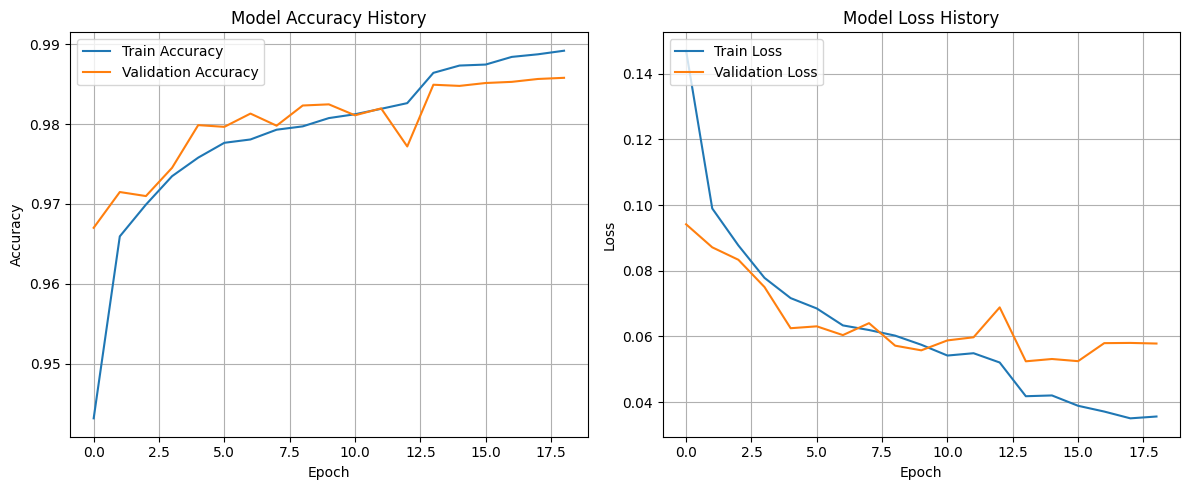

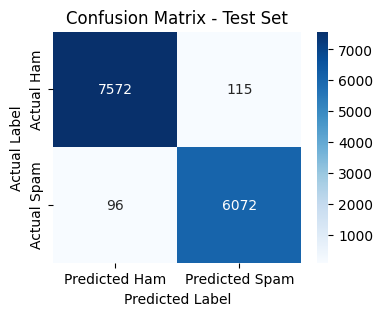


Model Evaluation Complete (PyTorch on XPU/CPU). 📊

MLP Spam Classifier model saved to: trained_models_pytorch_xpu\mlp_spam_classifier_xpu.pth 💾


In [8]:
import torch
import torch.nn as nn # For criterion
# Assume DataLoader is available, though typically from data splitting block
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# --- IPEX and Device Configuration (Assumed from Model Building Block) ---
try:
    import intel_extension_for_pytorch as ipex
    _IPEX_AVAILABLE = True
except ImportError:
    _IPEX_AVAILABLE = False

if 'device' not in locals(): # Defensive check if running block out of sequence
    if _IPEX_AVAILABLE and hasattr(torch, 'xpu') and torch.xpu.is_available():
        device = torch.device("xpu")
    else:
        device = torch.device("cpu")
    print(f"Device was not found, re-initializing to: {device} ⚠️")

print(f"Confirming device for evaluation: {device} 🚀")

# --- IMPORTANT: Model and DataLoaders (Assumed from previous blocks) ---
# This block assumes:
# 1. 'model' object is instantiated (e.g., MLPSpamClassifier) and has been trained.
# 2. 'test_loader' DataLoader is created.
# 3. 'criterion' (loss function) is defined for consistency in calculating test loss.
# 4. 'history' dictionary (from training block) is available for plotting.
try:
    _ = model
    _ = test_loader
    _ = criterion
    _ = history # From training block
    print("Model, Test DataLoader, Criterion, and Training History confirmed to be available. ✅")
except NameError:
    print("Error: 'model', 'test_loader', 'criterion', or 'history' not found. "
          "Please ensure the model building, data splitting, and model training blocks were executed first. ❌")
    exit()

# -----------------------------------------------------------------------------
## Model Evaluation on Test Set
# -----------------------------------------------------------------------------
print("\n--- Evaluating Model on Test Set (PyTorch on XPU/CPU) ---")

model.eval() # Set model to evaluation mode (crucial for inference)
test_loss = 0.0
all_labels = [] # To store all true labels
all_predictions_prob = [] # To store raw probabilities
all_predictions_binary = [] # To store binary (0 or 1) predictions

with torch.no_grad(): # Disable gradient calculations during testing to save memory and speed up
    for inputs, labels in test_loader:
        # Move inputs and labels to the designated device
        inputs, labels = inputs.to(device), labels.to(device)

        outputs_prob, _ = model(inputs) # Forward pass (model returns probabilities and logits)
        loss = criterion(outputs_prob, labels) # Calculate loss using probabilities
        test_loss += loss.item() * inputs.size(0)

        # Convert probabilities to binary classes (0 or 1) using a threshold (0.5)
        predicted_classes = (outputs_prob > 0.5).float()

        # Extend lists with data moved to CPU and converted to NumPy for sklearn metrics
        all_labels.extend(labels.cpu().numpy())
        all_predictions_prob.extend(outputs_prob.cpu().numpy())
        all_predictions_binary.extend(predicted_classes.cpu().numpy())

final_test_loss = test_loss / len(test_loader.dataset)
# Convert lists to NumPy arrays for scikit-learn functions
all_labels_np = np.array(all_labels).flatten()
all_predictions_binary_np = np.array(all_predictions_binary).flatten()
# all_predictions_prob_np = np.array(all_predictions_prob).flatten() # If you needed raw probs for ROC, etc.

# Calculate various metrics
final_test_accuracy = accuracy_score(all_labels_np, all_predictions_binary_np)
precision = precision_score(all_labels_np, all_predictions_binary_np)
recall = recall_score(all_labels_np, all_predictions_binary_np)
f1 = f1_score(all_labels_np, all_predictions_binary_np)
conf_matrix = confusion_matrix(all_labels_np, all_predictions_binary_np)
class_report = classification_report(all_labels_np, all_predictions_binary_np, target_names=['Ham', 'Spam'])

print(f"Test Loss: {final_test_loss:.4f}")
print(f"Test Accuracy: {final_test_accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1-Score: {f1:.4f}")

print("\nConfusion Matrix (Test Set):\n", conf_matrix)
print("\nClassification Report (Test Set):\n", class_report)

# --- Visualize Training History ---
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy History')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Model Loss History')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Visualize Confusion Matrix ---
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Ham', 'Predicted Spam'],
            yticklabels=['Actual Ham', 'Actual Spam'])
plt.title('Confusion Matrix - Test Set')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

print("\nModel Evaluation Complete (PyTorch on XPU/CPU). 📊")

# -----------------------------------------------------------------------------
## Save the Trained PyTorch Model
# -----------------------------------------------------------------------------
MODEL_SAVE_DIR = 'trained_models_pytorch_xpu' # A new directory name for clarity
os.makedirs(MODEL_SAVE_DIR, exist_ok=True)
# Save the model's state_dict (recommended way to save PyTorch models)
# This saves only the learned parameters, not the model architecture.
# To load, you'll need to re-instantiate MLPSpamClassifier and then load this state_dict.
PYTORCH_MODEL_SAVE_PATH = os.path.join(MODEL_SAVE_DIR, 'mlp_spam_classifier_xpu.pth')

try:
    # It's good practice to move the model to CPU before saving if you plan to load it on CPU
    # or if the target environment might not have XPU. If you only intend to load on XPU,
    # you can skip .cpu().
    model.cpu() # Move model to CPU before saving
    torch.save(model.state_dict(), PYTORCH_MODEL_SAVE_PATH)
    print(f"\nMLP Spam Classifier model saved to: {PYTORCH_MODEL_SAVE_PATH} 💾")
    model.to(device) # Move model back to device if you intend to use it further
except Exception as e:
    print(f"Error saving PyTorch model: {e} ❌")